In [2]:
import rioxarray
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

xr.set_options(keep_attrs=True, display_expand_data=False)

In [3]:
url = "https://github.com/opengeos/datasets/releases/download/raster/LC09_039035_20240708_90m.tif"
data = rioxarray.open_rasterio(url)
data

<xarray.DataArray (band: 7, y: 2563, x: 2485)> Size: 178MB
[44583385 values with dtype=float32]
Coordinates:
  * band         (band) int64 56B 1 2 3 4 5 6 7
  * x            (x) float64 20kB 5.824e+05 5.825e+05 ... 8.059e+05 8.06e+05
  * y            (y) float64 21kB 4.106e+06 4.105e+06 ... 3.875e+06 3.875e+06
    spatial_ref  int64 8B 0
Attributes: (12/96)
    ALGORITHM_SOURCE_SURFACE_REFLECTANCE:  LaSRC_1.6.0
    ALGORITHM_SOURCE_SURFACE_TEMPERATURE:  st_1.5.0
    CLOUD_COVER:                           0
    CLOUD_COVER_LAND:                      0
    COLLECTION_CATEGORY:                   T1
    COLLECTION_NUMBER:                     2
    ...                                    ...
    WRS_TYPE:                              2
    AREA_OR_POINT:                         Area
    _FillValue:                            -inf
    scale_factor:                          1.0
    add_offset:                            0.0
    long_name:                             ('SR_B1', 'SR_B2', 'SR_B3', 'SR_B4...

In [4]:
# Missing crs solutions
data = data.rio.write_crs("EPSG:32611", inplace=True)

In [5]:
data.rio.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]')

In [6]:
data_reprojected = data.rio.reproject("EPSG:4326")
print(data_reprojected.rio.crs)

EPSG:4326


In [7]:
# Define a bounding box (in the same CRS as the dataset)
bbox = [-115.391, 35.982, -114.988, 36.425]

# Clip the raster to the bounding box
clipped_data = data_reprojected.rio.clip_box(*bbox)

In [8]:
clipped_data.shape

(7, 492, 447)

In [9]:
data_reprojected.rio.bounds()

(-116.09697310704256,
 34.97106144548165,
 -113.55864087031607,
 37.093258845390615)

In [10]:
import geopandas as gpd

# Load a geojson with regions of interest
geojson_path = "https://github.com/opengeos/datasets/releases/download/places/las_vegas_bounds_utm.geojson"
bounds = gpd.read_file(geojson_path)

# Clip the raster to the shape
clipped_data2 = data.rio.clip(bounds.geometry, bounds.crs)

In [11]:
clipped_data2.shape

(7, 522, 514)

In [ ]:
# slice using xarray, more simple than rioxarray which is based on rasterio
min_x, max_x = -115.391, -114.988
min_y, max_y = 35.982, 36.425
subset = data_reprojected.sel(
    band=[1, 2, 3], x=slice(min_x, max_x), y=slice(max_y, min_y)
)  # Slice y in reverse order
subset.shape

(3, 491, 447)

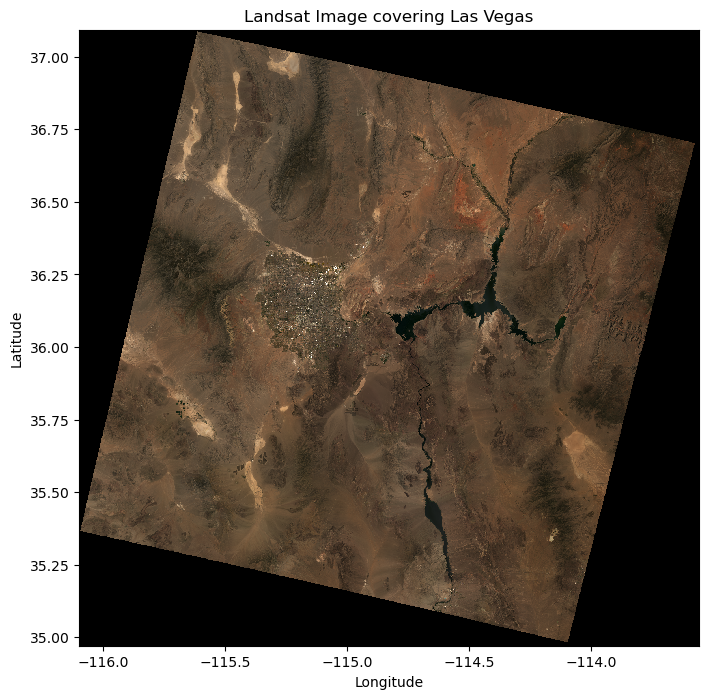

In [20]:
plt.figure(figsize=(8, 8))
data_reprojected.sel(band=[4, 3, 2]).plot.imshow(vmin=0, vmax=0.6)
plt.title("Landsat Image covering Las Vegas")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

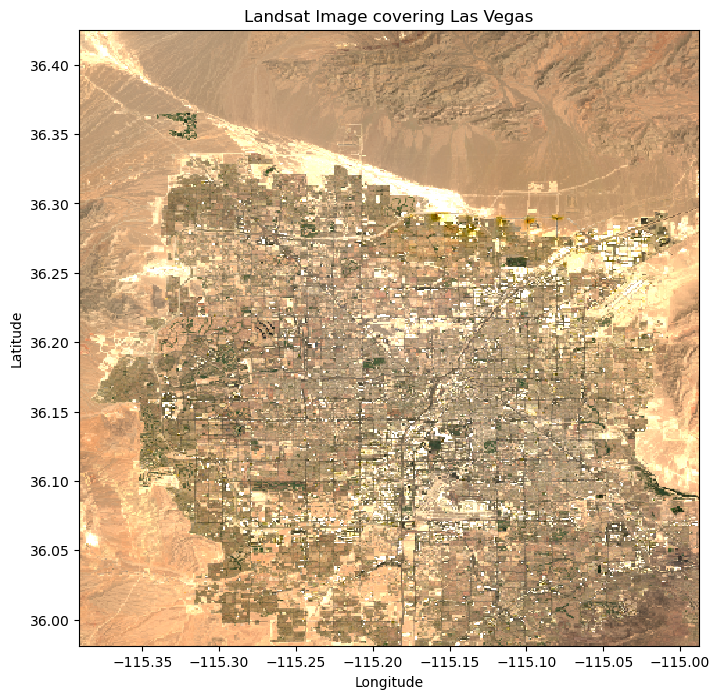

In [14]:
# Plot the raster data
plt.figure(figsize=(8, 8))
clipped_data.sel(band=[4, 3, 2]).plot.imshow(vmin=0, vmax=0.3)
plt.title("Landsat Image covering Las Vegas")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

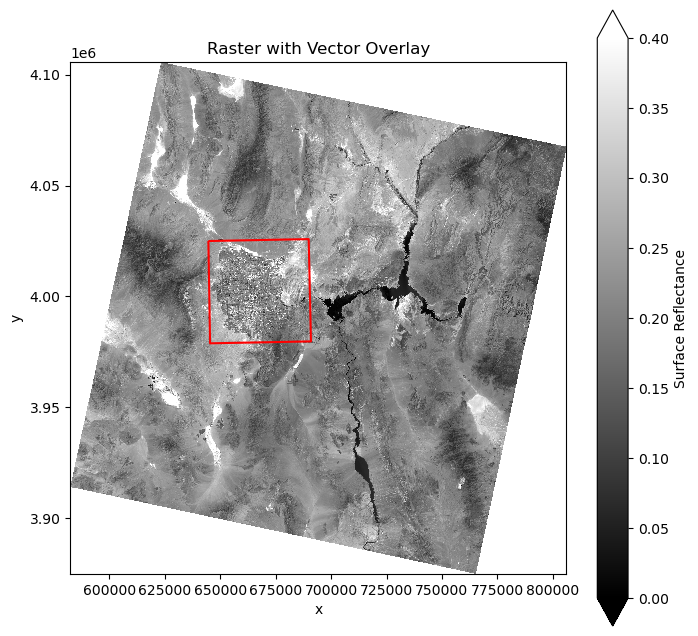

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
data.attrs["long_name"] = "Surface Reflectance"  # Update the long_name attribute
data.sel(band=4).plot.imshow(ax=ax, vmin=0, vmax=0.4, cmap="gray")
bounds.boundary.plot(ax=ax, color="red")
plt.title("Raster with Vector Overlay")
plt.show()

In [16]:
data.attrs

{'ALGORITHM_SOURCE_SURFACE_REFLECTANCE': 'LaSRC_1.6.0',
 'ALGORITHM_SOURCE_SURFACE_TEMPERATURE': 'st_1.5.0',
 'CLOUD_COVER': 0,
 'CLOUD_COVER_LAND': 0,
 'COLLECTION_CATEGORY': 'T1',
 'COLLECTION_NUMBER': 2,
 'DATA_SOURCE_AIR_TEMPERATURE': 'VIIRS',
 'DATA_SOURCE_ELEVATION': 'GLS2000',
 'DATA_SOURCE_OZONE': 'VIIRS',
 'DATA_SOURCE_PRESSURE': 'Calculated',
 'DATA_SOURCE_REANALYSIS': 'GEOS-5 IT',
 'DATA_SOURCE_WATER_VAPOR': 'VIIRS',
 'DATE_ACQUIRED': '2024-07-08',
 'DATE_PRODUCT_GENERATED': 1720562288000,
 'DATUM': 'WGS84',
 'EARTH_SUN_DISTANCE': 1.016687,
 'ELLIPSOID': 'WGS84',
 'GEOMETRIC_RMSE_MODEL': 3.828,
 'GEOMETRIC_RMSE_MODEL_X': 2.822,
 'GEOMETRIC_RMSE_MODEL_Y': 2.586,
 'GEOMETRIC_RMSE_VERIFY': 1.342,
 'GRID_CELL_SIZE_REFLECTIVE': 30,
 'GRID_CELL_SIZE_THERMAL': 30,
 'GROUND_CONTROL_POINTS_MODEL': 1015,
 'GROUND_CONTROL_POINTS_VERIFY': 244,
 'GROUND_CONTROL_POINTS_VERSION': 5,
 'IMAGE_QUALITY_OLI': 9,
 'IMAGE_QUALITY_TIRS': 9,
 'L1_DATE_PRODUCT_GENERATED': '2024-07-08T23:15:25Z',
 'L